In [1]:
import gym

import copy
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import json
import math
import random
import numpy as np
import pickle
from tqdm import tqdm

from collections import namedtuple, defaultdict, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
random.seed(0)
np.random.seed(0)

In [3]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

### Реализуем крестики-нолики

In [4]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows, n_cols, n_win, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)
    
    def getState2d(self):
        return np.array(list(map(int, self.getHash()))).reshape(1, self.n_rows, self.n_cols)

    def action_from_int(self, action_int):
        return (int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

### Реализуем случайный агент

In [5]:
class RandomAgent:
    def __init__(self):
        self.is_eval = True
        
    def consume(self, reward):
        pass
    
    def choose_action(self, env):
        obs, actions = env.getHash(), env.getEmptySpaces()
        actions = [env.int_from_action(action) for action in actions]
        action = np.random.choice(actions)
        tup_action = env.action_from_int(action)
        return tup_action
        
    def learn(self):
        pass
    
    def save(self, path):
        pass
    
    def load(self, path):
        pass

### Реализуем q-learning агент

In [6]:
class Agent:
    def __init__(self, q_sa, alpha, gamma, 
                 eps=0.05, eps_decay=1.0):
        self.q_sa = q_sa
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.eps_decay = eps_decay
        self.is_eval = False
        self.reset()
        
    def reset(self):
        self.hist = []

    def choose_action(self, env):
        obs, actions = env.getHash(), env.getEmptySpaces()
        actions = [env.int_from_action(action) for action in actions]
        q_vals = self.q_sa[obs][np.array(actions)]
        ind = np.argmax(q_vals)
        action = actions[ind]
        if not self.is_eval and np.random.uniform() < self.eps:
            action = np.random.choice(actions)
        self.hist.append([obs, action])
        tup_action = env.action_from_int(action)
        return tup_action
    
    def update_q(self, table1, table2, reward, obs, action, n_obs):
        if obs is not None:
            table1[obs][action] = table1[obs][action] + self.alpha * (reward \
                                    + self.gamma * np.max(table2[n_obs]) - table1[obs][action])
        self.eps *= self.eps_decay
    
    def learn(self, reward):
        self.hist.reverse()
        next_state = None
        for i, (state, action) in enumerate(self.hist):
            if i == 0:
                self.q_sa[state][action] = reward
            else:
                self.update_q(self.q_sa, self.q_sa, 0, state, action, next_state)
            next_state = state

    def load_state_dict(self, states):
        self.q_sa = deepcopy(states)

    def get_state_dict(self):
        return deepcopy(self.q_sa)
    
    def save(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self.q_sa, f)
            
    def load(self, path):
        with open(path, 'rb') as f:
            self.q_sa = pickle.load(f)

### Здесь реализация функций обучения и валидации

In [14]:
def step(env, player):
    action = player.choose_action(env)
    _, reward, done, _ = env.step(action)
    return reward, done

def play_episode(env, player1, player2):
    done = False
    env.reset()
    players = [player1, player2]
    idx = 0
    while not done:
        reward, done = step(env, players[idx])
        idx = 1 - idx
    
    assert reward >= -1, reward
    player1.learn(reward)
    player2.learn(-reward)
    return reward
        
def train(env, player1, player2, num_episodes=10 ** 4):
    player1.is_eval = False
    player2.is_eval = False
    rewards = []
    for _ in range(num_episodes):
        player1.reset()
        player2.reset()
        reward = play_episode(env, player1, player2)
        rewards.append(reward)
    env.close()
    return np.mean(rewards)

def eval(env, player1, player2, random=True, num_episodes=10 ** 3, crosses=True):
    player1.is_eval = True
    player2.is_eval = True
    rewards = []
    players = []
    if crosses or random is False:
        players.append(player1)
    if random:
        players.append(RandomAgent())
    if not crosses or random is False:
        players.append(player2)

    assert len(players) == 2, players
    
    for _ in range(num_episodes):
        done = False
        env.reset()
        idx = 0
        while not done:
            player = players[idx]
            action = player.choose_action(env)
            _, reward, done, _ = env.step(action)
            idx = 1 - idx
        rewards.append(reward)
    return np.mean(rewards)

### Напишем функцию, куда можно передать параметры доски, а она обучит агентов и нарисует графики

In [29]:
def defaultd():
    return np.zeros(N_ROWS * N_COLS)    

def tabular_q_learning(n_iter, verbose=False, step_size=100):
    CROSS_STATES_PATH = f"weights/tql_crosses_{N_ROWS}_{N_COLS}.pkl"
    NAUGHTS_STATES_PATH = f"weights/tql_naughts_{N_ROWS}_{N_COLS}.pkl"
    
    env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
        
    tql_player1 = Agent(defaultdict(defaultd), ALPHA, GAMMA, EPS, EPS_DECAY)
    tql_player2 = Agent(defaultdict(defaultd), ALPHA, GAMMA, EPS, EPS_DECAY)
    
    max_cross = 0
    min_naughts = 0
    
    cross_vs_rand = []
    naughts_vs_rand = []
    cross_vs_naughts = []

    for i in tqdm(range(n_iter)):
        train(env, tql_player1, tql_player2, step_size)
        c_r = eval(env, tql_player1, tql_player2, random=True, num_episodes=step_size, crosses=True)
        n_r = eval(env, tql_player1, tql_player2, random=True, num_episodes=step_size, crosses=False)
        
        cross_vs_rand.append(c_r)
        naughts_vs_rand.append(n_r)
        
        if c_r > max_cross:
            max_cross = c_r
            tql_player1.save(CROSS_STATES_PATH)
        if n_r < min_naughts:
            min_naughts = n_r
            tql_player2.save(NAUGHTS_STATES_PATH)
            
        if verbose:
            print(f"Player1 vs Random {c_r}, Player2 vs Random {n_r}")
            
    tql_player1.load(CROSS_STATES_PATH)
    tql_player2.load(NAUGHTS_STATES_PATH)
    score = eval(env, tql_player1, tql_player2, False, 10 ** 3, False)
    print(f"Best crosses played vs best naughts 1000 games with average result {score}")
    
    episodes = np.arange(len(cross_vs_rand)) * step_size
    
    figure(figsize=(12, 6))
    plt.plot(episodes, cross_vs_rand, label='crosses vs random')    
    plt.plot(episodes, -1 * np.array(naughts_vs_rand), label='naughtes vs random')    
    plt.legend()
    plt.title(f'{N_ROWS} x {N_COLS} game', fontsize=20)
    plt.xlabel('Episodes', fontsize=20)
    plt.ylabel('Average wins', fontsize=20)
    plt.grid(True)
    plt.show()

## Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


Best crosses played vs best naughts 1000 games with average result 1.0


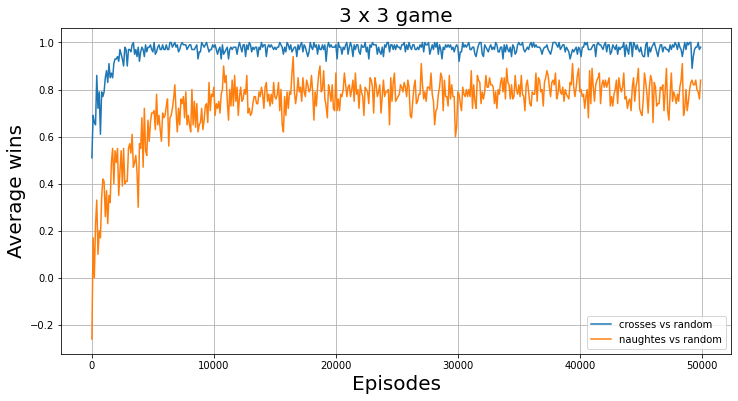

In [26]:
N_ROWS = 3
N_COLS = 3
N_WIN = 3

ALPHA, GAMMA, EPS, EPS_DECAY = 0.01, 1, 0.7, 1

tabular_q_learning(500, verbose=False)

## Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

100%|██████████| 50000/50000 [3:26:20<00:00,  4.04it/s]   


Best crosses played vs best naughts 1000 games with average result -1.0


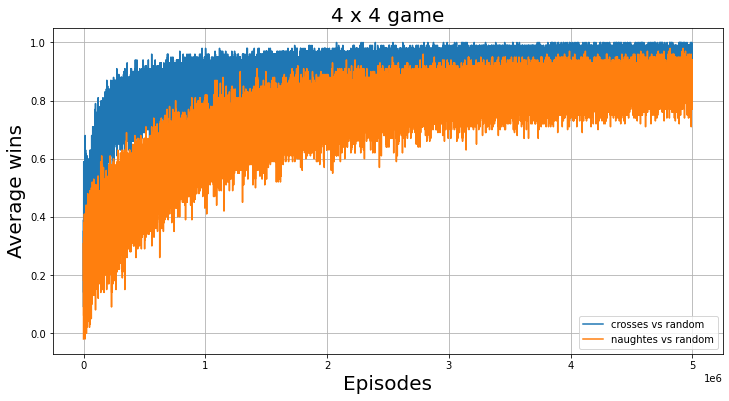

In [31]:
N_ROWS = 4
N_COLS = 4
N_WIN = 4

ALPHA, GAMMA, EPS, EPS_DECAY = 0.05, 1, 0.7, 1
tabular_q_learning(50000, verbose=False, step_size=100)

### Обучение доски 4 х 4 заняло намного больше времени чем обучение 3 х 3, поэтому доску 5 х 5 не стал пробовать 

## Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

### Здесь реализация обычного и dueling DQN

In [32]:
class DuelingDQN(nn.Module):
    def __init__(self, action_size):
        super(DuelingDQN, self).__init__()
        self.output_dim = action_size
        self.out_channels = 512
        self.hidden_size = 512
        
        self.conv_layer = nn.Conv2d(1, self.out_channels, 3, stride=1, padding=0)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(self.out_channels)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.feauture_layer = nn.Sequential(
            nn.Linear(self.out_channels, self.hidden_size),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.output_dim)
        )

    def forward(self, state):
        x = self.conv_layer(state.float())
        x = self.bn(self.relu(x))
        x = self.global_pool(x)
        x = x.view(x.shape[0], x.shape[1])

        features = self.feauture_layer(x)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean())
        return qvals
    
class DQN(nn.Module):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.output_dim = action_size
        self.out_channels = 512
        self.hidden_size = 512
        
        self.conv_layer = nn.Conv2d(1, self.out_channels, 3, stride=1, padding=0)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(self.out_channels)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.feauture_layer = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU()
        )

        self.q_values = nn.Sequential(
            nn.Linear(self.hidden_size, self.output_dim)
        )

    def forward(self, state):
        x = self.conv_layer(state.float())
        x = self.bn(self.relu(x))
        x = self.global_pool(x)
        x = x.view(x.shape[0], x.shape[1])

        features = self.feauture_layer(x)
        qvals = self.q_values(features)
        return qvals

### Опишем агента действующего с помощью DQN

In [33]:
def soft_update(target, source):
    for tp, sp in zip(target.parameters(), source.parameters()):
        tp.data.copy_((1 - TAU) * tp.data + TAU * sp.data)

class DeepAgent:
    def __init__(self, model, action_space, 
                 eps=0.05, eps_decay=1.0):
        self.model = model
        self.target_model = deepcopy(model)
        self.action_space = action_space
        self.eps = eps
        self.eps_decay = eps_decay
        self.is_eval = False
        self.buffer = deque(maxlen=BUFFER_SIZE)
        self.hist = []

        self.model.to(device)
        self.target_model.to(device)
        self.target_model.load_state_dict(deepcopy(self.model.state_dict()))
        self.target_model.eval()
        
        self.criterion = torch.nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0=100000, T_mult=1,)
    
    def consume(self, reward):
        if len(self.hist):
            self.hist.reverse()
            next_state = None
            prev_actions = None
            for i, (state, action, poss_actions) in enumerate(self.hist):
                if i == 0:
                    self.buffer.append((state, action, state, reward, 1, poss_actions))
                else:
                    self.buffer.append((state, action, next_state, 0, 0, poss_actions))
                next_state = state
                prev_actions = poss_actions
        self.hist = []
 
    def sample_batch(self):
        batch = random.sample(self.buffer, BATCH_SIZE)
        batch = list(zip(*batch))
        state, action, next_state, reward, done, poss_actions = batch
        state = torch.tensor(np.array(state, dtype=np.float32)).to(device)
        action = torch.tensor(np.array(action, dtype=np.int)).to(device)
        next_state = torch.tensor(np.array(next_state, dtype=np.float32)).to(device)
        reward = torch.tensor(np.array(reward, dtype=np.float32)).to(device)
        done = torch.tensor(np.array(done, dtype=np.float32)).to(device)
        poss_actions = torch.tensor(np.array(poss_actions, dtype=np.bool)).to(device)
        return (state, action, next_state, reward, done, poss_actions)
    
    def choose_action(self, env):
        obs, actions = env.getState2d(), env.getEmptySpaces()
        actions = [env.int_from_action(action) for action in actions]
        self.model.eval()
        actions = np.array(actions)
        state = torch.tensor(np.array(obs, dtype=np.float32)).to(device).unsqueeze(0)
        with torch.no_grad():
            q_vals = self.model(state)
        q_vals = q_vals.detach().cpu().numpy().reshape(-1)
        q_vals = q_vals[actions]
        action = actions[np.argmax(q_vals)]
        if not self.is_eval and np.random.uniform() < self.eps:
            action = np.random.choice(actions)
        if not self.is_eval:
            poss_actions = np.zeros(self.action_space)
            poss_actions[actions] = 1
            self.hist.append([obs, action, poss_actions])
        tup_action = env.action_from_int(action)
        return tup_action

    def train_step(self):
        (state, action, next_state, reward, done, actions) = self.sample_batch()
        with torch.no_grad():
            next_actions = self.model(next_state).detach()
            next_actions[actions] = -10 ** 6
            next_action = next_actions.argmax(dim=1)
            q_targets_next = self.target_model(next_state).gather(1, next_action.view(-1, 1))

        self.model.train()
        q_targets = reward.view(-1, 1) + GAMMA * q_targets_next * (1 - done.view(-1, 1))
        q_expected = self.model(state).gather(1, action.view(-1, 1))
        loss = self.criterion(q_expected, q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.update_target_network()

    def update_target_network(self):
        soft_update(self.target_model, self.model)
        
    def learn(self):
        self.train_step()
        
    def save(self, path):
        torch.save(self.model.state_dict(), path)
        
    def load(self, path):
        self.model.load_state_dict(torch.load(path))
        self.model.eval()

### Здесь вспомогательные функции для обучения

In [34]:
def step(env, player):
    action = player.choose_action(env)
    _, reward, done, _ = env.step(action)
    return reward, done

def play_episode(env, player1, player2, train1=True, train2=True):
    done = False
    env.reset()
    players = [player1, player2]
    idx = 0
    while not done:
        reward, done = step(env, players[idx])
        idx = 1 - idx
    player1.consume(reward)
    player2.consume(-reward)
    if train1:
        player1.learn()
    if train2:
        player2.learn()
    return reward

def train(env, player1, player2, num_episodes=10 ** 2, train1=True, train2=True):
    rewards = []
    player1.is_eval = False
    player2.is_eval = False
    for _ in range(num_episodes):
        reward = play_episode(env, player1, player2, train1, train2)
        rewards.append(reward)
    env.close()
    return np.mean(rewards)

### Тут функция которая берет на вход параметры доски и тип архитектуры модели, и обучает агентов

In [35]:
def dqn_play(architecture=DQN, num_iter=100, verbose=False, step_size=100):
    env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
    
    model1 = architecture(N_ROWS * N_COLS)
    model2 = architecture(N_ROWS * N_COLS)
    nn_player1 = DeepAgent(model1, N_ROWS * N_COLS, EPS)
    nn_player2 = DeepAgent(model2, N_ROWS * N_COLS, EPS)
    random_player = RandomAgent()
    
    CROSS_STATES_PATH = f"weights/{model1.__class__.__name__}_crosses_{N_ROWS}_{N_COLS}.pkl"
    NAUGHTS_STATES_PATH = f"weights/{model2.__class__.__name__}_naughts_{N_ROWS}_{N_COLS}.pkl"

    cross_vs_rand = []
    naughts_vs_rand = []
    
    max_cross = 0
    min_naughts = 0
    
    for _ in range(INITIAL_STEPS):
        play_episode(env, nn_player1, nn_player2, train1=False, train2=False)
    
    for i in tqdm(range(num_iter)):
        train(env, nn_player1, nn_player2, step_size, train1=True, train2=True)
        c_r = eval(env, nn_player1, random_player, True, step_size, True)
        n_r = eval(env, random_player, nn_player2, True, step_size, False)
        cross_vs_rand.append(c_r)
        naughts_vs_rand.append(n_r)

        if c_r > max_cross:
            max_cross = c_r
            nn_player1.save(CROSS_STATES_PATH)
            
        if n_r < min_naughts:
            min_naughts = n_r
            nn_player2.save(NAUGHTS_STATES_PATH)
            
        if verbose:
            print(f"Player1 vs Random {c_r}, Player2 vs Random {n_r}")
    
    nn_player1.load(CROSS_STATES_PATH)
    nn_player2.load(NAUGHTS_STATES_PATH)
    score = eval(env, nn_player1, nn_player2, False, 10 ** 3, False)
    print(f"Best crosses played vs best naughts 1000 games with average result {score}")
    episodes = np.arange(len(cross_vs_rand)) * step_size
    figure(figsize=(12, 6))
    plt.plot(episodes, cross_vs_rand, label='crosses vs random')    
    plt.plot(episodes, -1 * np.array(naughts_vs_rand), label='naughtes vs random')    
    plt.legend()
    plt.title(f'{N_ROWS} x {N_COLS} game', fontsize=20)
    plt.xlabel('Episodes', fontsize=20)
    plt.ylabel('Average wins', fontsize=20)
    plt.grid(True)
    plt.show()

### Обучим доску 3x3 обычным DQN

  0%|          | 0/100 [00:00<?, ?it/s]/home/azamat/miniconda3/envs/conda_work/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/azamat/miniconda3/envs/conda_work/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more

Best crosses played vs best naughts 1000 games with average result 1.0


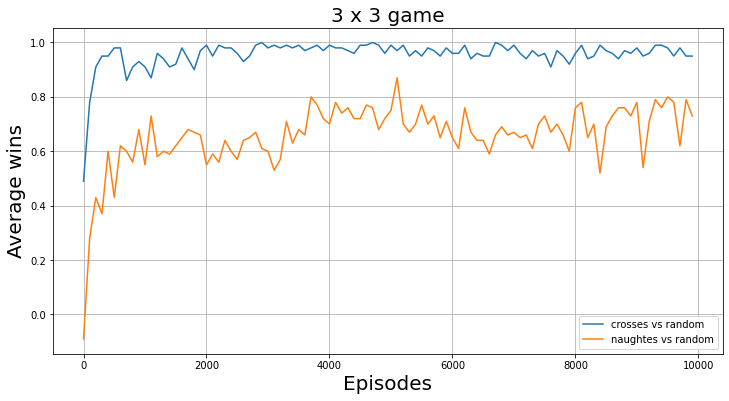

In [36]:
TAU = 0.01
EPS = 0.5
GAMMA = 0.9
INITIAL_STEPS = 256
BATCH_SIZE = 256
LEARNING_RATE = 1e-5
BUFFER_SIZE = 10 ** 5
device = torch.device("cpu")

N_ROWS = 3
N_COLS = 3
N_WIN = 3
dqn_play(num_iter=100, verbose=False)

### Обучим доску 4x4 обычным DQN

  0%|          | 0/200 [00:00<?, ?it/s]/home/azamat/miniconda3/envs/conda_work/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/azamat/miniconda3/envs/conda_work/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more

Best crosses played vs best naughts 1000 games with average result 1.0


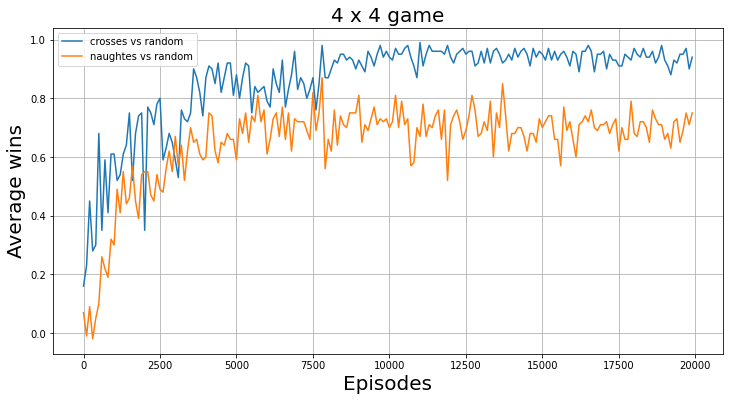

In [37]:
TAU = 0.01
EPS = 0.5
GAMMA = 0.9
INITIAL_STEPS = 256
BATCH_SIZE = 256
LEARNING_RATE = 1e-5
BUFFER_SIZE = 10 ** 5
device = torch.device("cpu")

N_ROWS = 4
N_COLS = 4
N_WIN = 4
dqn_play(num_iter=200, verbose=False)

### Обучим доску 3x3 DuelingDQN

  0%|          | 0/100 [00:00<?, ?it/s]/home/azamat/miniconda3/envs/conda_work/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/azamat/miniconda3/envs/conda_work/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more

Best crosses played vs best naughts 1000 games with average result 1.0


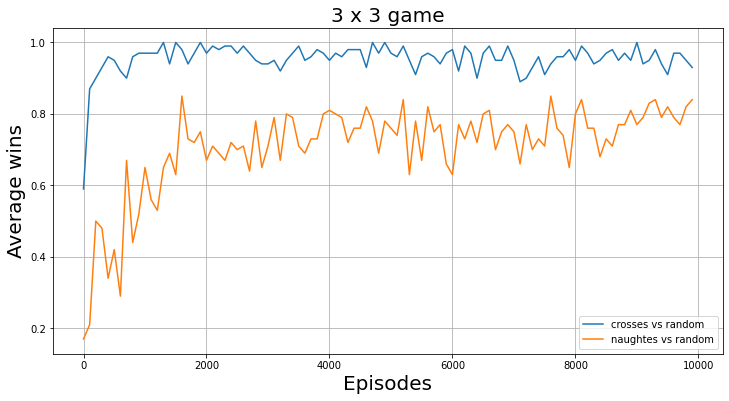

In [38]:
TAU = 0.01
EPS = 0.5
GAMMA = 0.9
INITIAL_STEPS = 256
BATCH_SIZE = 256
LEARNING_RATE = 1e-5
BUFFER_SIZE = 10 ** 5
device = torch.device("cpu")

N_ROWS = 3
N_COLS = 3
N_WIN = 3
dqn_play(DuelingDQN, num_iter=100, verbose=False)

### Обучим доску 4x4 DuelingDQN

  0%|          | 0/200 [00:00<?, ?it/s]/home/azamat/miniconda3/envs/conda_work/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/azamat/miniconda3/envs/conda_work/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more

Best crosses played vs best naughts 1000 games with average result 0.0


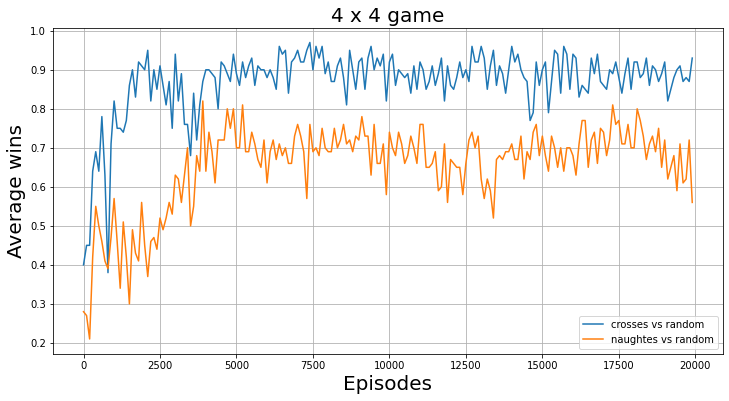

In [39]:
TAU = 0.01
EPS = 0.5
GAMMA = 0.9
INITIAL_STEPS = 256
BATCH_SIZE = 256
LEARNING_RATE = 1e-5
BUFFER_SIZE = 10 ** 5
device = torch.device("cpu")

N_ROWS = 4
N_COLS = 4
N_WIN = 4
dqn_play(DuelingDQN, num_iter=200, verbose=False)

## Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

### Тут реализуется класс Node, он наследуется (почему-то) от TicTacToe. Это немножко облегчило работу с MCTS

In [40]:
class Node(TicTacToe):
    def __init__(self, n_rows, n_cols, n_win, clone=None):
        super().__init__(n_rows, n_cols, n_win, clone)
        self.action = None
        
    def get_child(self, player):
        child = Node(self.n_rows, self.n_cols, self.n_win, clone=self)
        action = player.choose_action(child)
        _, reward, done, _ = child.step(action)
        child.action = action
        return child, reward, done
    
    def find_random_child(self):
        return self.get_child(RandomAgent())
    
    def find_children(self):
        children = set()
        actions = self.getEmptySpaces()
        for action in actions:
            child = Node(0, 0, 0, clone=self)
            child.step(action)
            child.action = action
            children.add(child)
        return children
    
    def __eq__(self, other):
        return self.getHash() == other.getHash() and self.curTurn == other.curTurn

    def __hash__(self):
        return hash(self.getHash() + str(self.curTurn))

### Тут сам класс Rollout, который принимает как параметр агентов для крестиков и ноликов (агент может быть либо случайным, либо любым другим заранее обученным агентом)

In [41]:
class Rollout:
    def __init__(self, player1, player2, num_rolls=50, eps=0.5):
        self.player1 = player1
        self.player2 = player2
        self.player1.eps = eps
        self.player2.eps = eps
        self.is_eval = True
        self.num_rolls = num_rolls
        
    def get_reward_done(self, node):
        node.curTurn = -node.curTurn
        reward = node.isTerminal()
        node.curTurn = -node.curTurn
        reward = reward if reward is not None else 0
        done = node.gameOver
        return reward, done
        
    def simulate(self, node):
        node_ = deepcopy(node)
        reward, done = self.get_reward_done(node)
        first_action = None
        while not done:
            player = self.player1 if node_.curTurn == 1 else self.player2
            node_, reward, done = node_.get_child(player)
            if first_action is None:
                first_action = node_.action
        return reward, first_action
    
    def choose_action(self, node):
        actions = defaultdict(list)
        direction = node.curTurn
        for _ in range(self.num_rolls):
            reward, action = self.simulate(node)
            actions[action].append(reward * direction)
        values = list(actions.values())
        keys = list(actions.keys())
        action = keys[values.index(max(values))]
        return action

In [42]:
def rollout_play(env, agent, steps=100):
    random_player = RandomAgent()
    
    cross_vs_rand = []
    naughts_vs_rand = []

    c_r = eval(env, agent, random_player, True, steps, True)
    n_r = eval(env, random_player, agent, True, steps, False)
    cross_vs_rand.append(c_r)
    naughts_vs_rand.append(n_r)

    print(f"Player1 vs Random {c_r}, Player2 vs Random {n_r}")

### Сыграем против случайного агента роллаутом со случайной стратегией. Доска 3х3

In [43]:
## Play vs random player using random rollouts

N_ROWS = 3
N_COLS = 3
N_WIN = 3

env = Node(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
agent = Rollout(RandomAgent(), RandomAgent(), 50)
rollout_play(env, agent, 100)

Player1 vs Random 0.92, Player2 vs Random -0.52


### Сыграем против случайного агента роллаутом с неслучайной стратегией. Доска 3х3

In [45]:
## PLay vs random player using rollouts based on learned tabular q-function

tql_player1 = Agent(defaultdict(defaultd), ALPHA, GAMMA, EPS, EPS_DECAY)
tql_player1.load(f"weights/tql_crosses_{N_ROWS}_{N_COLS}.pkl")
tql_player2 = Agent(defaultdict(defaultd), ALPHA, GAMMA, EPS, EPS_DECAY)
tql_player2.load(f"weights/tql_naughts_{N_ROWS}_{N_COLS}.pkl")

agent = Rollout(tql_player1, tql_player2, 50, 0.01)
rollout_play(env, agent, 100)

Player1 vs Random 0.85, Player2 vs Random -0.27


### То же самое, но на доске 4х4 до 4

In [46]:
N_ROWS = 4
N_COLS = 4
N_WIN = 4

env = Node(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
agent = Rollout(RandomAgent(), RandomAgent(), 50)
rollout_play(env, agent, 100)

tql_player1 = Agent(defaultdict(defaultd), ALPHA, GAMMA, EPS, EPS_DECAY)
tql_player1.load(f"weights/tql_crosses_{N_ROWS}_{N_COLS}.pkl")
tql_player2 = Agent(defaultdict(defaultd), ALPHA, GAMMA, EPS, EPS_DECAY)
tql_player2.load(f"weights/tql_naughts_{N_ROWS}_{N_COLS}.pkl")

agent = Rollout(tql_player1, tql_player2, 50, 0.01)
rollout_play(env, agent, 100)

Player1 vs Random 0.85, Player2 vs Random -0.6
Player1 vs Random 0.53, Player2 vs Random -0.88


## Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [47]:
from abc import ABC, abstractmethod
import math


class MCTS:
    "Monte Carlo tree searcher. First rollout the tree then choose a move."

    def __init__(self, rollout, exploration_weight=1):
        self.rollout = rollout
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight

    def choose(self, node):
        "Choose the best successor of node. (Choose a move in the game)"
        if node.gameOver:
            raise RuntimeError(f"choose called on terminal node {node}")
    
        if node not in self.children:
            for _ in range(5):
                self.do_rollout(node)

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward
        
        next_node = max(self.children[node], key=score)
        return deepcopy(next_node)
    
    def choose_action(self, node):
        next_node = self.choose(node)
        return next_node.action

    def do_rollout(self, node):
        node_ = deepcopy(node)
        path = self._select(node_)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        path = []
        while True:
            path.append(deepcopy(node))
            if node not in self.children or not self.children[node]:
                return path

            unexplored = self.children[node].difference(self.children.keys())
            if unexplored:
                n = unexplored.pop()
                path.append(deepcopy(n))
                return path
            node = self._uct_select(node)

    def _expand(self, node):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded
        self.children[node] = deepcopy(node.find_children())

    def _simulate(self, node):
        "Returns the reward for a random simulation (to completion) of `node`"
        return self.rollout.simulate(node)[0]

    def _backpropagate(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
            self.N[node] += 1
            if reward == 0:
                self.Q[node] += 0.5
            if reward < 0 and node.curTurn == 1:
                self.Q[node] += 1
            elif reward < 0 and node.curTurn == -1:
                self.Q[node] -= 1
            if reward > 0 and node.curTurn == -1:
                self.Q[node] += 1
            elif reward > 0 and node.curTurn == 1:
                self.Q[node] -= 1

    def _uct_select(self, node):
        assert all(n in self.children for n in self.children[node])

        log_N_vertex = math.log(self.N[node])

        def uct(n):
            "Upper confidence bound for trees"
            return self.Q[n] / self.N[n] + self.exploration_weight * math.sqrt(
                log_N_vertex / self.N[n]
            )

        return max(self.children[node], key=uct)

In [48]:
class MCTSAgent:
    def __init__(self, tree, num_rollouts):
        self.is_eval = True
        self.tree = tree
        self.num_rollouts = num_rollouts
        
    def choose_action(self, env):
        for _ in range(self.num_rollouts):
            self.tree.do_rollout(env)
        action = self.tree.choose_action(env)
        return action

### Сыграем против случайного агента на доске 3х3 используя MCTS со случайной стратегией

In [49]:
N_ROWS = 3
N_COLS = 3
N_WIN = 3

def play(rollout, episodes=100):
    env = Node(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
    tree = MCTS(rollout, 1.4)

    for _ in range(5000):
        tree.do_rollout(env)

    mcts_agent = MCTSAgent(tree, 10)

    rollout_play(env, mcts_agent)
    
    tql_player1 = Agent(defaultdict(defaultd), ALPHA, GAMMA, EPS, EPS_DECAY)
    tql_player1.load(f"weights/tql_crosses_{N_ROWS}_{N_COLS}.pkl")
    tql_player2 = Agent(defaultdict(defaultd), ALPHA, GAMMA, EPS, EPS_DECAY)
    tql_player2.load(f"weights/tql_naughts_{N_ROWS}_{N_COLS}.pkl")

    model1 = DuelingDQN(N_ROWS * N_COLS)
    model2 = DuelingDQN(N_ROWS * N_COLS)
    dqn_player1 = DeepAgent(model1, N_ROWS * N_COLS, 0.1)
    dqn_player2 = DeepAgent(model2, N_ROWS * N_COLS, 0.1)
    dqn_player1.load(f"weights/{model1.__class__.__name__}_crosses_{N_ROWS}_{N_COLS}.pkl")
    dqn_player2.load(f"weights/{model2.__class__.__name__}_naughts_{N_ROWS}_{N_COLS}.pkl")
    
    score = eval(env, tql_player1, mcts_agent, random=False, num_episodes=episodes)
    print(f"q_learning vs mcts on board {N_ROWS}x{N_COLS}: {score}")
    
    score = eval(env, mcts_agent, tql_player2, random=False, num_episodes=episodes)
    print(f"mcts vs q_learning on board {N_ROWS}x{N_COLS}: {score}")
    
    score = eval(env, agent, mcts_agent, random=False, num_episodes=episodes)
    print(f"rollouts vs mcts on board {N_ROWS}x{N_COLS}: {score}")
    
    score = eval(env, mcts_agent, agent, random=False, num_episodes=episodes)
    print(f"mcts vs rollouts on board {N_ROWS}x{N_COLS}: {score}")
    
    score = eval(env, dqn_player1, mcts_agent, random=False, num_episodes=episodes)
    print(f"dqn vs mcts on board {N_ROWS}x{N_COLS}: {score}")
    
    score = eval(env, mcts_agent, dqn_player2, random=False, num_episodes=episodes)
    print(f"mcts vs dqn_player2 on board {N_ROWS}x{N_COLS}: {score}")

In [50]:
rollout = Rollout(RandomAgent(), RandomAgent())
play(rollout)

Player1 vs Random 0.94, Player2 vs Random -0.64
q_learning vs mcts on board 3x3: 0.03
mcts vs q_learning on board 3x3: 1.0
rollouts vs mcts on board 3x3: -0.81
mcts vs rollouts on board 3x3: 0.98
dqn vs mcts on board 3x3: 1.0
mcts vs dqn_player2 on board 3x3: -1.0


#### Видно что mcts обыгрывает q-learning и обычные роллауты, но проигрывает dqn играя крестиками, а играя ноликами сводит игру к ничьей с теми же q-learning и обычные роллауты, так же проигрывая dqn

### То же самое, но уже с MCTS с неслучайной стратегией (стратегия из первого пункта)

In [51]:
rollout = Rollout(tql_player1, tql_player2)
play(rollout)

Player1 vs Random 0.88, Player2 vs Random -0.46
q_learning vs mcts on board 3x3: 0.2
mcts vs q_learning on board 3x3: 0.64
rollouts vs mcts on board 3x3: 0.05
mcts vs rollouts on board 3x3: 0.38
dqn vs mcts on board 3x3: 1.0
mcts vs dqn_player2 on board 3x3: -1.0


#### Тут ситуация та же, единственное с неслучайной стратегией mcts уже играет хуже (видимо,  реализация неправильная, так как exploration почти отсутствует)

### Теперь для доски 4х4 до 4

In [52]:
N_ROWS = 4
N_COLS = 4
N_WIN = 4

### MCTS со случайной стратегией

In [53]:
rollout = Rollout(RandomAgent(), RandomAgent())
play(rollout)

Player1 vs Random 0.74, Player2 vs Random -0.59
q_learning vs mcts on board 4x4: -0.66
mcts vs q_learning on board 4x4: 0.6
rollouts vs mcts on board 4x4: 0.31
mcts vs rollouts on board 4x4: -0.08
dqn vs mcts on board 4x4: -0.29
mcts vs dqn_player2 on board 4x4: 0.54


#### Здесь mcts проигрывает обычным роллаутам (думаю итерации оказалось мало), но уже выигрывает у dqn

### MCTS с неслучайной стратегией

In [54]:
rollout = Rollout(tql_player1, tql_player2)
play(rollout)

Player1 vs Random 0.7, Player2 vs Random -0.57
q_learning vs mcts on board 4x4: -0.87
mcts vs q_learning on board 4x4: 0.09
rollouts vs mcts on board 4x4: 0.46
mcts vs rollouts on board 4x4: 0.12
dqn vs mcts on board 4x4: -0.16
mcts vs dqn_player2 on board 4x4: 0.57


#### Здесь примерно те же расклады

## Во всех случаях mcts несильно доминирует над случайной стратегией, что плохо (